In [4]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob

GIsis = nx.from_edgelist([[1,5],[5,3],[1,2],[2,6],[6,4],[6,7]])
#GIsis = nx.from_edgelist([[0, 1], [0, 2], [1, 10], [2, 9], [10, 7], [9, 8], [3, 6], [4, 6], [6, 7], [5, 8]])
sonda = []
sondaTemp = []

replicationTemp = []

overhead_DataPlane_MPINT = []
overhead_ControlPlane_MPINT = []
overhead_DataPlane_MPolkaCRC8 = []
overhead_ControlPlane_MPolkaCRC8 = []
overhead_DataPlane_MPolkaCRC16 = []
overhead_ControlPlane_MPolkaCRC16 = []
overhead_DataPlane_INTClassico = []
overhead_ControlPlane_INTClassico = []
overhead_MPINT_Temp = []
overhead_MPolkaCRC8_Temp = []
overhead_MPolkaCRC16_Temp = []
overhead_INTClassico_Temp = []

def removeBadValues():
    listTopology = glob.glob('topologyZoo/*.gml')
    for topology in listTopology:
        try:
            G = nx.read_gml(topology,destringizer=int,label='id') #
        except:
            print('<READ ERROR 1>',topology,'removed')
            os.remove(topology)
    print('PASSED TEST 1')
    for topology in listTopology:
        try:
            appendGraphToDataFrame(df=pd.DataFrame(),G=G)
        except:
            print('<READ ERROR 2>',topology,'removed')
            os.remove(topology)
    print('PASSED TEST 2')


def StateOverheadHeatMap(maxNodes,maxReplication):
    replicationArr = np.arange(1.0,maxReplication,0.1)
    newArr = []
    for i in range (1,maxNodes+1):
        for j in replicationArr:
            newArr.append([i,round(j,1)])

    df = pd.DataFrame(data=newArr,columns=['Number of Nodes','Replication Average per Node'])
    df['State Overhead'] = df.apply(lambda x : x['Number of Nodes']*(1+2*(x['Replication Average per Node'])),axis=1)
    heatMap = df.pivot('Number of Nodes','Replication Average per Node','State Overhead')
    sns.heatmap(data=heatMap, annot=False, fmt="f", vmin=-0.05,cmap="rocket_r")
    plt.gca().invert_yaxis()
    plt.show()
    return heatMap

def GraphToMST(G):

    topologyName = G.graph['Network'] #Hooka o atributo network que identifica o nome da Topologia
    isBackBone = G.graph['Backbone']
    numberOfNodes = G.number_of_nodes()
    numberOfEdges = G.number_of_edges()
    #print(isBackBone, numberOfNodes, numberOfEdges)


    edgeList = list(map(list,G.edges()))
    #print(edgeList)
    G = nx.from_edgelist(edgeList)
    T = nx.minimum_spanning_tree(G,algorithm='prim')
    edgeList = list(map(list, T.edges()))
    T = nx.from_edgelist(edgeList)
    #print(T)
    return T,topologyName,isBackBone,numberOfNodes,numberOfEdges


def toDataframe(df,topology,isBackBone,numberOfNodes,numberOfEdges):
    #Overhead por abordagem
    overheadDP_mPolkaCRC8 = sum(sum(overhead_DataPlane_MPolkaCRC8,[]))
    overheadDP_mPolkaCRC16 = sum(sum(overhead_DataPlane_MPolkaCRC16,[]))
    overheadDP_mPINT = sum(sum(overhead_DataPlane_MPINT,[]))
    overheadDP_INTClassico = sum(sum(overhead_DataPlane_INTClassico,[]))

    overheadCP_mPolkaCRC8 = sum(overhead_ControlPlane_MPolkaCRC8)
    overheadCP_mPolkaCRC16 = sum(overhead_ControlPlane_MPolkaCRC16)
    overheadCP_mPINT = sum(overhead_ControlPlane_MPINT)
    overheadCP_INTClassico = sum(overhead_ControlPlane_INTClassico)

    replicationPerNode = sum(replicationTemp)/numberOfNodes
    maxReplication = max(replicationTemp)
    stateOverhead = 0
    for n in replicationTemp:
        stateOverhead += (1 + 2*n)

    matrixOverhead = {}
    matrixOverhead['Topology'] = [topology,topology]
    matrixOverhead['IsBackBone'] = [isBackBone,isBackBone]
    matrixOverhead['Number of Nodes'] = [numberOfNodes,numberOfNodes]
    matrixOverhead['Number of Edges'] = [numberOfEdges,numberOfEdges]
    matrixOverhead['Replication Average per Node'] = [replicationPerNode,replicationPerNode]
    matrixOverhead['Max Replication'] = [maxReplication,maxReplication]
    matrixOverhead['State Overhead'] = [stateOverhead,stateOverhead]
    matrixOverhead['Where'] = ['DataPlane','ControlPlane']
    matrixOverhead['MPINT'] = [overheadDP_mPINT,overheadCP_mPINT]
    matrixOverhead['MPolka CRC8'] = [overheadDP_mPolkaCRC8,overheadCP_mPolkaCRC8]
    matrixOverhead['MPolka CRC16'] = [overheadDP_mPolkaCRC16,overheadCP_mPolkaCRC16]
    matrixOverhead['INT Clássico'] = [overheadDP_INTClassico,overheadCP_INTClassico]
    df2 = pd.DataFrame(data=matrixOverhead)
    result = pd.concat([df,df2],ignore_index=True)
    return result

def appendGraphToDataFrame(df,G):
    G,topologyName,isBackBone,numberOfNodes,numberOfEdges = GraphToMST(G)
    sondaAux = dfs_init(G,node)
    #print('Matriz de Sondas',topologyName,' =',sondaAux,'\n')
    df = toDataframe(df,topologyName,isBackBone,numberOfNodes,numberOfEdges)
    return df

def appendAllTopologysToDataFrame(df):
    listTopology = glob.glob('topologyZoo/*.gml')
    for topology in listTopology:
        G = nx.read_gml(topology,destringizer=int,label='id')
        df = appendGraphToDataFrame(df,G)

    return df

def readTopologyData(path):
    edgeList = []

    with open(path,'r') as arq:
        lines = arq.readlines()
    
    for i in range(len(lines)):
        line = lines[i].split(' ')
        line.pop()
        line = list(map(int,line))
        edgeList.append(line)
    
    return edgeList

def calculaOverheads(sonda,hops):

    tamanhoSonda = len(sonda)
    if(hops == 0):
        return 0 #SEM SALTOS, SEM OVERHEAD
    
    #PARA O MPINT
    overhead_MPINT_Temp.append(calculaOverheadMPINT(tamanhoSonda,hops))

    #PARA O MPOLKA CRC8 e CRC16
    overheadCRC8, overheadCRC16 = calculaOverheadMPolka(tamanhoSonda)
    overhead_MPolkaCRC8_Temp.append(overheadCRC8)
    overhead_MPolkaCRC16_Temp.append(overheadCRC16)

    #PARA O INT CLASSICO
    overhead_INTClassico_Temp.append(calculaOverheadINTClassico(hops))

def calculaOverheadMPINT(tamanhoSonda,hops):
    #CABEÇALHO DO MPINT
    mPINT_Ethernet = 14
    mPINT_Ip = 20
    mPINT_INTHeader = 12
    mPINT_StackINT = 48
    mPINT_PathHeader = 1
    mPINT_StackPath = 4
    fixo_MPINT = mPINT_Ethernet + mPINT_Ip + mPINT_INTHeader + mPINT_PathHeader

    if(hops == 0):
        return 0 #SEM SALTOS, SEM OVERHEAD

    #Overhead para o MPINT
    routeOverheadMPINT = mPINT_StackPath * hops
    telemetryOverheadMPINT = mPINT_StackINT * (tamanhoSonda-1)
    overhead = fixo_MPINT + routeOverheadMPINT + telemetryOverheadMPINT
    return overhead

def calculaOverheadMPolka(tamanhoSonda):
    #CABEÇALHO DO MPOLKA
    mPolka_Ethernet = 14
    mPolka_Ip = 20
    mPolka_INTHeader = 12
    mPolka_StackINT = 48
    mPolka_routeID_CRC8 = 7
    mPolka_routeID_CRC16 = 14
    fixo_MPolkaCRC8 = mPolka_Ethernet + mPolka_routeID_CRC8 + mPolka_Ip + mPolka_INTHeader
    fixo_MPolkaCRC16 = mPolka_Ethernet + mPolka_routeID_CRC16 + mPolka_Ip + mPolka_INTHeader

    #Overhead para o MPolka
    telemetryOverheadMPolka = mPolka_StackINT * (tamanhoSonda-1)
    overheadCRC8 = fixo_MPolkaCRC8 + telemetryOverheadMPolka
    overheadCRC16 = fixo_MPolkaCRC16 + telemetryOverheadMPolka

    return overheadCRC8,overheadCRC16

def calculaOverheadINTClassico(hops):
    #CABEÇALHO DO INT CLASSICO
    mPINT_Ethernet = 14
    mPINT_Ip = 20
    mPINT_INTHeader = 12
    mPINT_StackINT = 48
    mPINT_PathHeader = 1
    mPINT_StackPath = 4
    fixo_MPINT = mPINT_Ethernet + mPINT_Ip + mPINT_INTHeader + mPINT_PathHeader

    if(hops == 0):
        return 0 #SEM SALTOS, SEM OVERHEAD

    #Overhead para o MPINT
    routeOverheadMPINT = mPINT_StackPath * hops
    telemetryOverheadMPINT = mPINT_StackINT * hops
    overhead = fixo_MPINT + routeOverheadMPINT + telemetryOverheadMPINT
    return overhead

def deadEndRelease(sonda,hops):
    #RELEASE OVERHEAD MPINT
    overhead_DataPlane_MPINT.append(overhead_MPINT_Temp.copy())
    overhead_ControlPlane_MPINT.append(calculaOverheadMPINT(len(sondaTemp)+1,hops))
    overhead_MPINT_Temp.clear()

    #RELEASE OVERHEAD MPOLKA
    overhead_DataPlane_MPolkaCRC8.append(overhead_MPolkaCRC8_Temp.copy())
    overhead_DataPlane_MPolkaCRC16.append(overhead_MPolkaCRC16_Temp.copy())
    overheadCRC8, overheadCRC16 = calculaOverheadMPolka(len(sondaTemp)+1)
    overhead_ControlPlane_MPolkaCRC8.append(overheadCRC8)
    overhead_ControlPlane_MPolkaCRC16.append(overheadCRC16)
    overhead_MPolkaCRC8_Temp.clear()
    overhead_MPolkaCRC16_Temp.clear()

    #RELEASE OVERHEAD INT CLASSICO
    overhead_DataPlane_INTClassico.append(overhead_INTClassico_Temp.copy())
    overhead_ControlPlane_INTClassico.append(calculaOverheadINTClassico(hops))
    overhead_INTClassico_Temp.clear()

    #RELEASE PROBE
    sonda.append(sondaTemp.copy())
    sondaTemp.clear()

def calculaReplicationInDFS(grau):
    if(grau == 1):
        replication = 1
    else:
        replication = grau - 1

    replicationTemp.append(replication)

def fixReplicationVector(G,v):
    replicationTemp.pop(0) #Pop the wrong replication value (Sender Node)
    replicationTemp.append(G.degree(v)) #Append the right value (Sender Node)

    return stateOverhead,maxReplication

def dfs(G,v,visited,hops,previousHop): #Retorna a matriz de sondas do MPolka
    visited[v] = True
    sondaTemp.append(v)
    grau = G.degree(v)
    calculaReplicationInDFS(grau)
    calculaOverheads(sondaTemp,hops)
    hops += 1
    for w in G.neighbors(v):
        if grau == 1: #DEADEND
            deadEndRelease(sonda,hops)
        if not visited[w]:
            if grau == 2: #TRANSMISSÃO
                dfs(G,w,visited,hops,previousHop)
            else: #BIFURCAÇÃO
                previousHop = hops
                dfs(G,w,visited,hops,previousHop)
    return sonda

def dfs_init(G,v):
    visited=[False] * (G.number_of_nodes() + 100)
    sonda.clear()
    overhead_DataPlane_MPINT.clear()
    overhead_ControlPlane_MPINT.clear()
    overhead_DataPlane_MPolkaCRC8.clear()
    overhead_ControlPlane_MPolkaCRC8.clear()
    overhead_DataPlane_MPolkaCRC16.clear()
    overhead_ControlPlane_MPolkaCRC16.clear()
    overhead_DataPlane_INTClassico.clear()
    overhead_ControlPlane_INTClassico.clear()
    replicationTemp.clear()
    sondaAux = dfs(G,v,visited,hops=0,previousHop=0)

    return sondaAux


Digite o nó que enviará a sonda em G: 


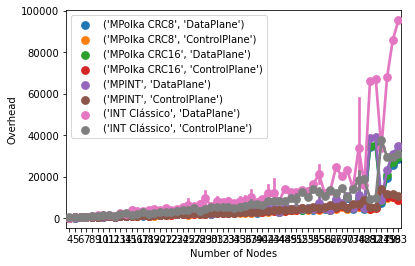

In [5]:
print('Digite o nó que enviará a sonda em G: ')
node = int(input())

df = pd.DataFrame(columns=['Topology','Where','IsBackBone','Number of Nodes','Number of Edges','Replication Average per Node','Max Replication','State Overhead','MPolka CRC8','MPolka CRC16','MPINT','INT Clássico']) #Empty Row Dataframe

sondaIsis = dfs_init(GIsis,node)
#print('Matriz de Sondas Isis = ',sondaIsis,'\n')

df = toDataframe(df,'Isis',1,7,6) #DataFrame Isis Example
df = appendAllTopologysToDataFrame(df)
df.to_csv('overhead.csv',index=False)


######################################## PLOT AREA #################################################

#sns.catplot(x="Topology", y="MPolka CRC8", hue="Where",kind="bar", data=df, errorbar = None);
#plt.show()
#sns.catplot(x="Topology", y="MPolka CRC16", hue="Where",kind="bar", data=df, errorbar = None);
#plt.show()
#sns.catplot(x="Topology", y="MPINT", hue="Where",kind="bar", data=df, errorbar = None);
#plt.show()
#sns.catplot(x="Topology", y="INT Clássico", hue="Where",kind="bar", data=df, errorbar = None);
#plt.show()

df2 = df[['Where','Number of Nodes','MPolka CRC8','MPolka CRC16','MPINT','INT Clássico']]
dfm = df2.melt(id_vars=['Where','Number of Nodes'], var_name='Type', value_name='Overhead')
#sns.catplot(x="Number of Nodes", y="Overhead", hue='Type', data=dfm, kind='point');
sns.pointplot(x="Number of Nodes", y="Overhead", hue=dfm[['Type','Where']].apply(tuple,axis=1), data=dfm);
#df2.sort_values(by=['Number of Nodes'],inplace=True)
#df2 = df2.set_index('Number of Nodes')
#df2.plot()
#plt.show()
#hMap = StateOverheadHeatMap(maxNodes=50,maxReplication=2.0)